In [11]:
%load_ext autoreload
%autoreload 2
%cd ..

import numpy as np
import matplotlib.pyplot as plt
from src.ortools_solver import CVRP_solver
from src.utils import random_choose_candidate, distance_calculator, calculate_distance_matrix, show_matrix, get_optimized_sequence, print_command
from src.QAP_solver import calculate_T, CVRP_QAP
import pygmtools as pygm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/home/yq-mew/yq/chem1906/Projects


In [2]:
D = np.ones((96,96))
for i in range(96):
    for j in range(96):
        if i//8 == j//8:
            if i-j == -1:
                D[i,j] = 0

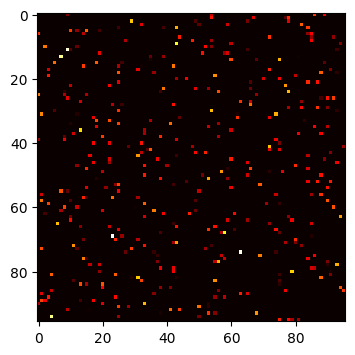

In [3]:
# generate the random addition matrix
# row is the source, column is the destination
a= np.eye(96)
a = random_choose_candidate(96,96,4)
show_matrix(a)
# randomly shuffle the rows
#np.random.shuffle(a)
# binarize the matrix as 0 and 1
a[a>0] = 1

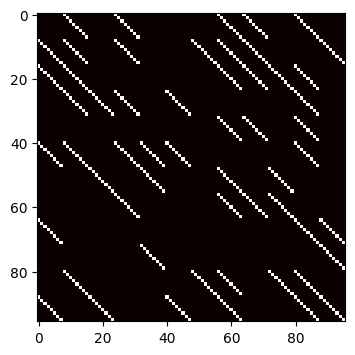

In [9]:
# generate the non-symmetric matrix
# devide a 96*96 matrix into 12*12 8*8 matrix
# randomly choose n matrix to add a diagonal matrix
a = np.zeros((96,96))
# randomly pick n number from 0 to 144
picked_submatrix = np.random.choice(144, 56, replace=False)
n = 0
for i in range(12):
    for j in range(12):
        if n in picked_submatrix:
            a[i*8:(i+1)*8, j*8:(j+1)*8] = np.eye(8)
        n += 1
show_matrix(a)

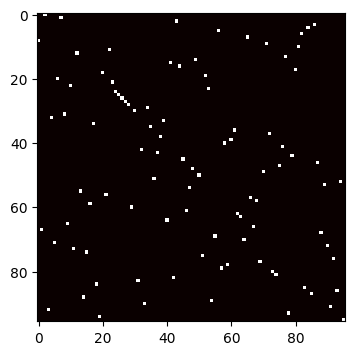

In [5]:
column_permutation = np.eye(96)
# Function to swap two columns in a matrix
def swap_columns(matrix, col1, col2):
    matrix[:, [col1, col2]] = matrix[:, [col2, col1]]

# pick an integer from 0 to 10 with gaussian distribution
for i in range(20):
    num_permutation = np.random.normal(5, 2)
    num_permutation = int(num_permutation)
    # randomly swipe two columns n times
    for j in range(num_permutation):
        exchange_columns = np.random.choice(96, 2, replace=False)
        swap_columns(column_permutation, exchange_columns[0], exchange_columns[1])
show_matrix(column_permutation)

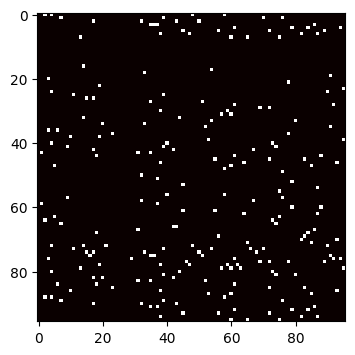

In [6]:
a = np.dot(a, column_permutation)
show_matrix(a)

In [7]:
# generate the job pair
jobs = np.argwhere(a)
volume = [a[i,j] for i,j in jobs]
volume = np.array(volume)
#distance_matrix = calculate_distance_matrix(jobs)
#S,E = calculate_S_E(jobs)
#D_prime = calculate_D_prime(D, S, E)

In [30]:
test_cost, test_P, new_jobs, test_seq = CVRP_QAP(jobs, iteration=5)

iter=0, cost=355.0 after CVRP
iter=0, cost=355.0 after QAP
iter=1, cost=346.0 after CVRP
iter=1, cost=345.0 after QAP
iter=2, cost=352.0 after CVRP
iter=2, cost=352.0 after QAP
iter=3, cost=345.0 after CVRP
iter=3, cost=345.0 after QAP
iter=4, cost=354.0 after CVRP
iter=4, cost=354.0 after QAP
solution cost=350


In [31]:
distance_matrix = calculate_distance_matrix(new_jobs)
VRP_distance, VRP_recorder = CVRP_solver(distance_matrix)
recorder = get_optimized_sequence(VRP_recorder)

In [32]:
sequence = recorder.flatten()
sequence = sequence[sequence!=-1] -1
command_line = print_command(sequence, new_jobs)
np.savetxt('optimized_command_line.csv',command_line,fmt='%s',delimiter=',')

In [8]:
jobs = np.argwhere(a)
unoptimized_command_line = print_command(np.array(range(jobs.shape[0])),jobs)
np.savetxt('unoptimized_command_line.csv',unoptimized_command_line,fmt='%s',delimiter=',')

In [33]:
stat = []
for i in range(1,20):
    experiments = random_choose_candidate(96,96,i)
    jobs = np.argwhere(experiments)
    distance_matrix = calculate_distance_matrix(jobs)
    optimized_distance, _, new_jobs, recorder= CVRP_QAP(jobs,iteration=20)
    VRP_distance, _ = CVRP_solver(distance_matrix)
    non_optimized_distance = distance_calculator(jobs)
    stat.append((i,non_optimized_distance,optimized_distance, VRP_distance))
stat = np.array(stat)

/mnt/c/Users/runzh/OneDrive/Documents/2025/pipette_scheduling/src/utils.py:17: RuntimeWarning: invalid value encountered in divide
  random_vector = random_vector / random_vector.sum(axis=0, keepdims=1)


iter=0, cost=93.0 after CVRP
iter=0, cost=73.0 after QAP
iter=1, cost=74.0 after CVRP
iter=1, cost=72.0 after QAP
iter=2, cost=71.0 after CVRP
iter=2, cost=67.0 after QAP
iter=3, cost=64.0 after CVRP
iter=3, cost=63.0 after QAP
iter=4, cost=65.0 after CVRP
iter=4, cost=64.0 after QAP
iter=5, cost=67.0 after CVRP
iter=5, cost=67.0 after QAP
iter=6, cost=67.0 after CVRP
iter=6, cost=67.0 after QAP
iter=7, cost=67.0 after CVRP
iter=7, cost=67.0 after QAP
iter=8, cost=67.0 after CVRP
iter=8, cost=67.0 after QAP
iter=9, cost=67.0 after CVRP
iter=9, cost=67.0 after QAP
iter=10, cost=67.0 after CVRP
iter=10, cost=67.0 after QAP
iter=11, cost=67.0 after CVRP
iter=11, cost=67.0 after QAP
iter=12, cost=67.0 after CVRP
iter=12, cost=67.0 after QAP
iter=13, cost=67.0 after CVRP
iter=13, cost=67.0 after QAP
iter=14, cost=67.0 after CVRP
iter=14, cost=67.0 after QAP
iter=15, cost=67.0 after CVRP
iter=15, cost=67.0 after QAP
iter=16, cost=67.0 after CVRP
iter=16, cost=67.0 after QAP
iter=17, cost=67.

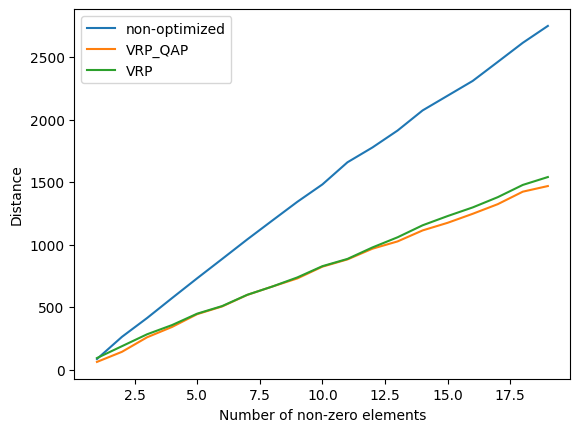

In [34]:
# plot the result
plt.plot(stat[:,0],stat[:,1],label='non-optimized')
plt.plot(stat[:,0],stat[:,2],label='VRP_QAP')
plt.plot(stat[:,0],stat[:,3],label='VRP')
plt.legend()
plt.xlabel('Number of non-zero elements')
plt.ylabel('Distance')
plt.show()

In [12]:
def matrix_to_sequence(matrix,optimization_iteration=5):
    jobs = np.argwhere(matrix)
    distance_matrix = calculate_distance_matrix(jobs)
    optimized_distance, P, new_jobs, seq = CVRP_QAP(jobs,iteration=optimization_iteration)
    non_optimized_distance = distance_calculator(jobs)
    return non_optimized_distance, optimized_distance

iter=0, cost=126.0 after CVRP


/u/yq/chem1906/anaconda3/envs/pipette_scheduling/lib/python3.9/site-packages/pygmtools/numpy_backend.py:308: RuntimeWarning: invalid value encountered in divide
  t0 = - alpha / beta


iter=0, cost=126.0 after QAP
iter=1, cost=123.0 after CVRP
iter=1, cost=123.0 after QAP
iter=2, cost=123.0 after CVRP
iter=2, cost=123.0 after QAP
iter=3, cost=123.0 after CVRP
iter=3, cost=123.0 after QAP
iter=4, cost=123.0 after CVRP
iter=4, cost=123.0 after QAP
solution cost=7


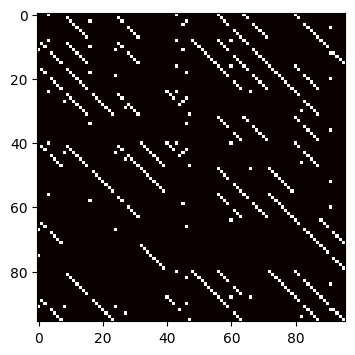

iter=0, cost=241.0 after CVRP


/u/yq/chem1906/anaconda3/envs/pipette_scheduling/lib/python3.9/site-packages/pygmtools/numpy_backend.py:308: RuntimeWarning: divide by zero encountered in divide
  t0 = - alpha / beta
/u/yq/chem1906/anaconda3/envs/pipette_scheduling/lib/python3.9/site-packages/pygmtools/numpy_backend.py:309: RuntimeWarning: invalid value encountered in multiply
  v = np.where(np.logical_or(beta >= 0, t0 >= 1), binary_v, v + t0 * (binary_v - v))


iter=0, cost=240.0 after QAP
iter=1, cost=220.0 after CVRP
iter=1, cost=220.0 after QAP
iter=2, cost=220.0 after CVRP
iter=2, cost=220.0 after QAP
iter=3, cost=220.0 after CVRP
iter=3, cost=220.0 after QAP
iter=4, cost=218.0 after CVRP
iter=4, cost=218.0 after QAP
solution cost=190


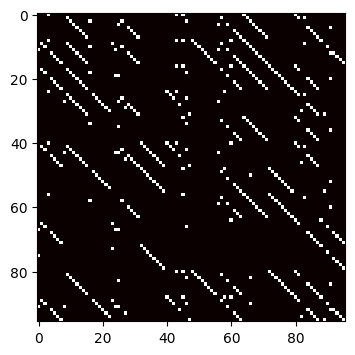

iter=0, cost=257.0 after CVRP
iter=0, cost=257.0 after QAP
iter=1, cost=257.0 after CVRP
iter=1, cost=257.0 after QAP
iter=2, cost=257.0 after CVRP
iter=2, cost=257.0 after QAP
iter=3, cost=257.0 after CVRP
iter=3, cost=257.0 after QAP
iter=4, cost=257.0 after CVRP
iter=4, cost=257.0 after QAP
solution cost=243


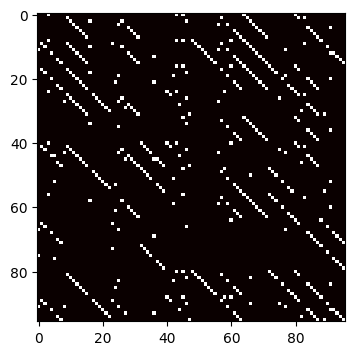

iter=0, cost=274.0 after CVRP
iter=0, cost=273.0 after QAP
iter=1, cost=266.0 after CVRP
iter=1, cost=266.0 after QAP
iter=2, cost=265.0 after CVRP
iter=2, cost=265.0 after QAP
iter=3, cost=266.0 after CVRP
iter=3, cost=266.0 after QAP
iter=4, cost=265.0 after CVRP
iter=4, cost=265.0 after QAP
solution cost=235


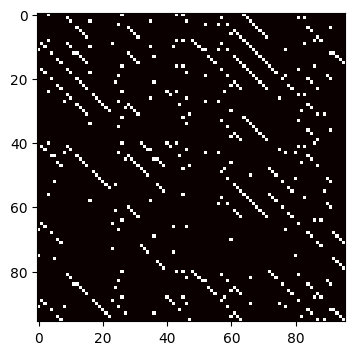

iter=0, cost=292.0 after CVRP
iter=0, cost=292.0 after QAP
iter=1, cost=292.0 after CVRP
iter=1, cost=292.0 after QAP
iter=2, cost=292.0 after CVRP
iter=2, cost=292.0 after QAP
iter=3, cost=292.0 after CVRP
iter=3, cost=292.0 after QAP
iter=4, cost=292.0 after CVRP
iter=4, cost=292.0 after QAP
solution cost=288


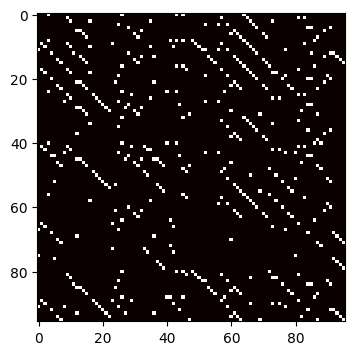

iter=0, cost=348.0 after CVRP
iter=0, cost=348.0 after QAP
iter=1, cost=348.0 after CVRP
iter=1, cost=348.0 after QAP
iter=2, cost=348.0 after CVRP
iter=2, cost=348.0 after QAP
iter=3, cost=348.0 after CVRP
iter=3, cost=348.0 after QAP
iter=4, cost=348.0 after CVRP
iter=4, cost=348.0 after QAP
solution cost=348


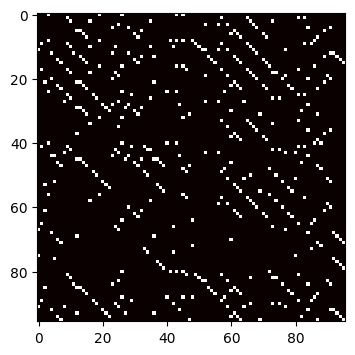

iter=0, cost=352.0 after CVRP
iter=0, cost=352.0 after QAP
iter=1, cost=352.0 after CVRP
iter=1, cost=352.0 after QAP
iter=2, cost=352.0 after CVRP
iter=2, cost=352.0 after QAP
iter=3, cost=352.0 after CVRP
iter=3, cost=352.0 after QAP
iter=4, cost=352.0 after CVRP
iter=4, cost=352.0 after QAP
solution cost=346


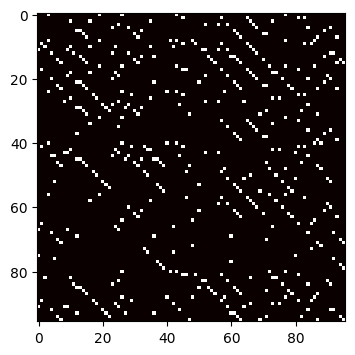

iter=0, cost=366.0 after CVRP
iter=0, cost=366.0 after QAP
iter=1, cost=361.0 after CVRP
iter=1, cost=361.0 after QAP
iter=2, cost=357.0 after CVRP
iter=2, cost=357.0 after QAP
iter=3, cost=357.0 after CVRP
iter=3, cost=357.0 after QAP
iter=4, cost=357.0 after CVRP
iter=4, cost=357.0 after QAP
solution cost=344


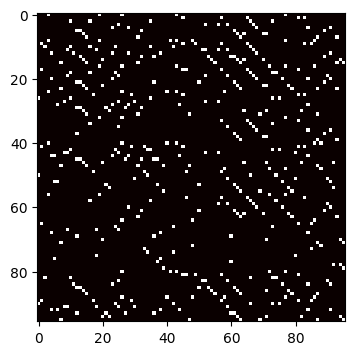

iter=0, cost=382.0 after CVRP
iter=0, cost=382.0 after QAP
iter=1, cost=382.0 after CVRP
iter=1, cost=382.0 after QAP
iter=2, cost=382.0 after CVRP
iter=2, cost=382.0 after QAP
iter=3, cost=382.0 after CVRP
iter=3, cost=382.0 after QAP
iter=4, cost=382.0 after CVRP
iter=4, cost=382.0 after QAP
solution cost=374


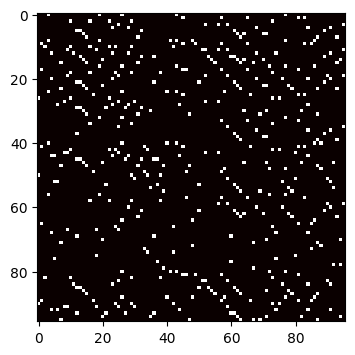

iter=0, cost=403.0 after CVRP
iter=0, cost=403.0 after QAP
iter=1, cost=392.0 after CVRP
iter=1, cost=393.0 after QAP
iter=2, cost=384.0 after CVRP
iter=2, cost=384.0 after QAP
iter=3, cost=384.0 after CVRP
iter=3, cost=384.0 after QAP
iter=4, cost=384.0 after CVRP
iter=4, cost=384.0 after QAP
solution cost=376


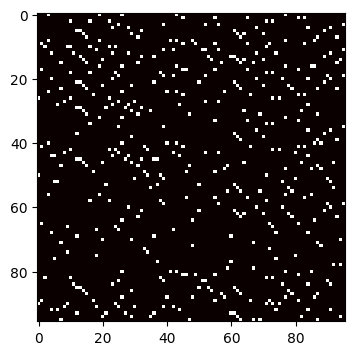

iter=0, cost=385.0 after CVRP
iter=0, cost=385.0 after QAP
iter=1, cost=381.0 after CVRP
iter=1, cost=381.0 after QAP
iter=2, cost=381.0 after CVRP
iter=2, cost=381.0 after QAP
iter=3, cost=381.0 after CVRP
iter=3, cost=381.0 after QAP
iter=4, cost=381.0 after CVRP
iter=4, cost=381.0 after QAP
solution cost=377


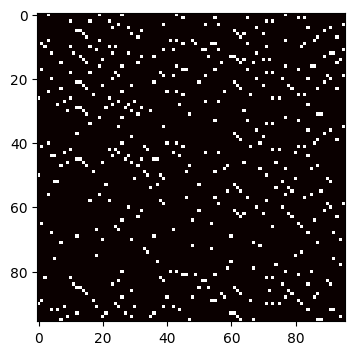

iter=0, cost=403.0 after CVRP
iter=0, cost=403.0 after QAP
iter=1, cost=403.0 after CVRP
iter=1, cost=403.0 after QAP
iter=2, cost=403.0 after CVRP
iter=2, cost=403.0 after QAP
iter=3, cost=403.0 after CVRP
iter=3, cost=403.0 after QAP
iter=4, cost=403.0 after CVRP
iter=4, cost=403.0 after QAP
solution cost=391


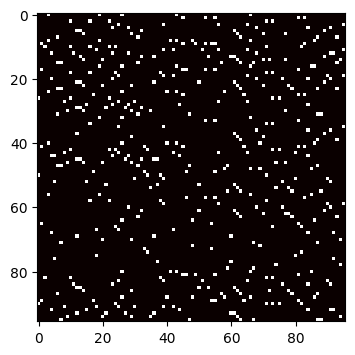

iter=0, cost=401.0 after CVRP
iter=0, cost=399.0 after QAP
iter=1, cost=391.0 after CVRP
iter=1, cost=391.0 after QAP
iter=2, cost=373.0 after CVRP
iter=2, cost=373.0 after QAP
iter=3, cost=373.0 after CVRP
iter=3, cost=373.0 after QAP
iter=4, cost=373.0 after CVRP
iter=4, cost=373.0 after QAP
solution cost=369


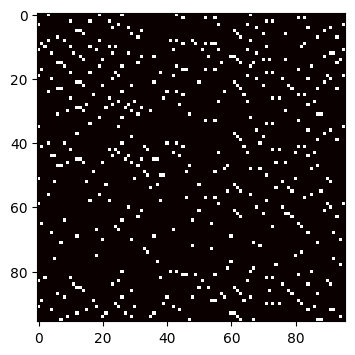

iter=0, cost=400.0 after CVRP
iter=0, cost=400.0 after QAP
iter=1, cost=397.0 after CVRP
iter=1, cost=397.0 after QAP
iter=2, cost=387.0 after CVRP
iter=2, cost=387.0 after QAP
iter=3, cost=387.0 after CVRP
iter=3, cost=387.0 after QAP
iter=4, cost=387.0 after CVRP
iter=4, cost=387.0 after QAP
solution cost=381


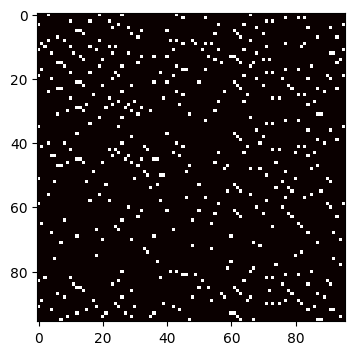

iter=0, cost=401.0 after CVRP
iter=0, cost=398.0 after QAP
iter=1, cost=392.0 after CVRP
iter=1, cost=390.0 after QAP
iter=2, cost=382.0 after CVRP
iter=2, cost=382.0 after QAP
iter=3, cost=382.0 after CVRP
iter=3, cost=382.0 after QAP
iter=4, cost=382.0 after CVRP
iter=4, cost=382.0 after QAP
solution cost=376


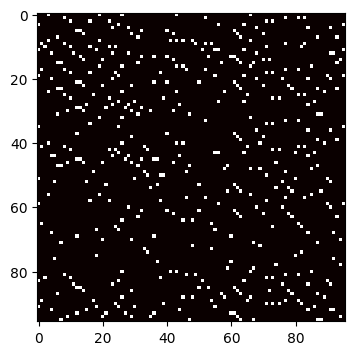

iter=0, cost=404.0 after CVRP
iter=0, cost=402.0 after QAP
iter=1, cost=389.0 after CVRP
iter=1, cost=389.0 after QAP
iter=2, cost=388.0 after CVRP
iter=2, cost=388.0 after QAP
iter=3, cost=383.0 after CVRP
iter=3, cost=383.0 after QAP
iter=4, cost=390.0 after CVRP
iter=4, cost=388.0 after QAP
solution cost=370


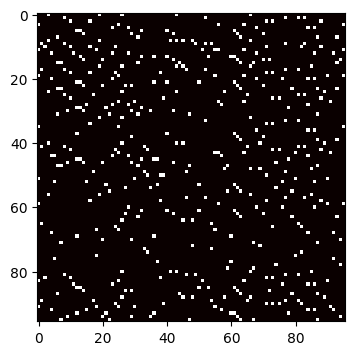

iter=0, cost=412.0 after CVRP
iter=0, cost=410.0 after QAP
iter=1, cost=392.0 after CVRP
iter=1, cost=392.0 after QAP
iter=2, cost=378.0 after CVRP
iter=2, cost=376.0 after QAP
iter=3, cost=374.0 after CVRP
iter=3, cost=372.0 after QAP
iter=4, cost=377.0 after CVRP
iter=4, cost=377.0 after QAP
solution cost=373


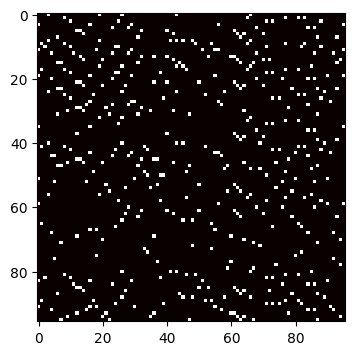

iter=0, cost=411.0 after CVRP
iter=0, cost=412.0 after QAP
iter=1, cost=408.0 after CVRP
iter=1, cost=405.0 after QAP
iter=2, cost=401.0 after CVRP
iter=2, cost=397.0 after QAP
iter=3, cost=392.0 after CVRP
iter=3, cost=392.0 after QAP
iter=4, cost=392.0 after CVRP
iter=4, cost=392.0 after QAP
solution cost=386


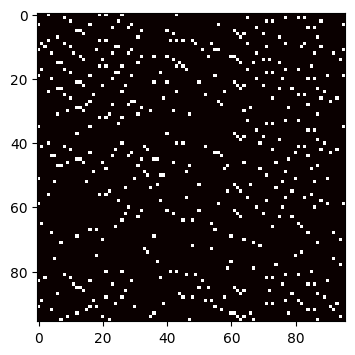

iter=0, cost=403.0 after CVRP
iter=0, cost=403.0 after QAP
iter=1, cost=410.0 after CVRP
iter=1, cost=410.0 after QAP
iter=2, cost=398.0 after CVRP
iter=2, cost=398.0 after QAP
iter=3, cost=398.0 after CVRP
iter=3, cost=398.0 after QAP
iter=4, cost=398.0 after CVRP
iter=4, cost=398.0 after QAP
solution cost=393


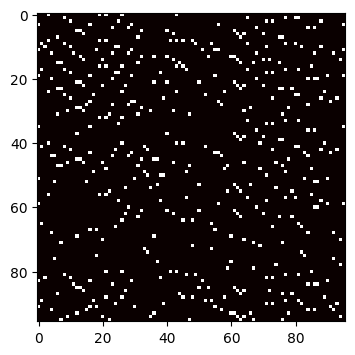

iter=0, cost=412.0 after CVRP
iter=0, cost=411.0 after QAP
iter=1, cost=402.0 after CVRP
iter=1, cost=405.0 after QAP
iter=2, cost=398.0 after CVRP
iter=2, cost=396.0 after QAP
iter=3, cost=393.0 after CVRP
iter=3, cost=391.0 after QAP
iter=4, cost=381.0 after CVRP
iter=4, cost=381.0 after QAP
solution cost=379


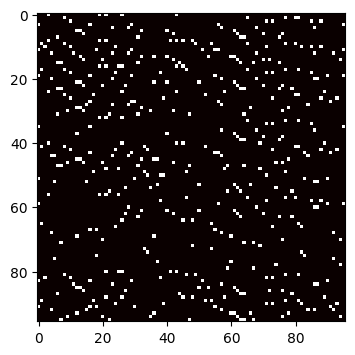

iter=0, cost=401.0 after CVRP
iter=0, cost=399.0 after QAP
iter=1, cost=397.0 after CVRP
iter=1, cost=397.0 after QAP
iter=2, cost=397.0 after CVRP
iter=2, cost=397.0 after QAP
iter=3, cost=397.0 after CVRP
iter=3, cost=397.0 after QAP
iter=4, cost=397.0 after CVRP
iter=4, cost=397.0 after QAP
solution cost=389


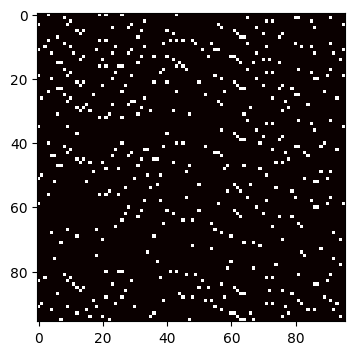

iter=0, cost=400.0 after CVRP
iter=0, cost=400.0 after QAP
iter=1, cost=413.0 after CVRP
iter=1, cost=411.0 after QAP
iter=2, cost=395.0 after CVRP
iter=2, cost=394.0 after QAP
iter=3, cost=402.0 after CVRP
iter=3, cost=402.0 after QAP
iter=4, cost=395.0 after CVRP
iter=4, cost=395.0 after QAP
solution cost=399


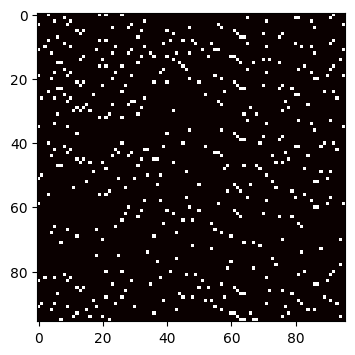

iter=0, cost=411.0 after CVRP
iter=0, cost=405.0 after QAP
iter=1, cost=384.0 after CVRP
iter=1, cost=384.0 after QAP
iter=2, cost=382.0 after CVRP
iter=2, cost=382.0 after QAP
iter=3, cost=382.0 after CVRP
iter=3, cost=382.0 after QAP
iter=4, cost=382.0 after CVRP
iter=4, cost=382.0 after QAP
solution cost=379


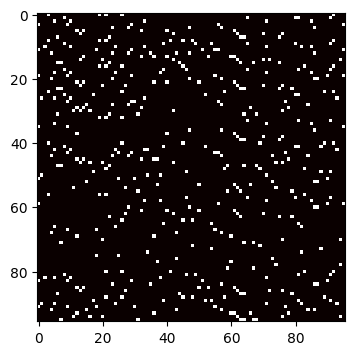

iter=0, cost=409.0 after CVRP
iter=0, cost=409.0 after QAP
iter=1, cost=409.0 after CVRP
iter=1, cost=409.0 after QAP
iter=2, cost=409.0 after CVRP
iter=2, cost=409.0 after QAP
iter=3, cost=409.0 after CVRP
iter=3, cost=409.0 after QAP
iter=4, cost=409.0 after CVRP
iter=4, cost=409.0 after QAP
solution cost=408


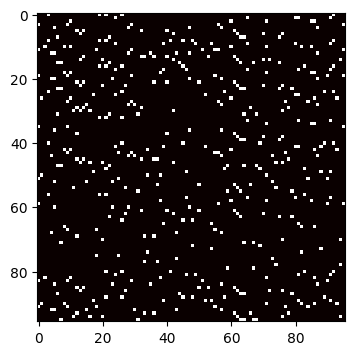

iter=0, cost=401.0 after CVRP
iter=0, cost=401.0 after QAP
iter=1, cost=407.0 after CVRP
iter=1, cost=406.0 after QAP
iter=2, cost=389.0 after CVRP
iter=2, cost=389.0 after QAP
iter=3, cost=389.0 after CVRP
iter=3, cost=389.0 after QAP
iter=4, cost=389.0 after CVRP
iter=4, cost=389.0 after QAP
solution cost=387


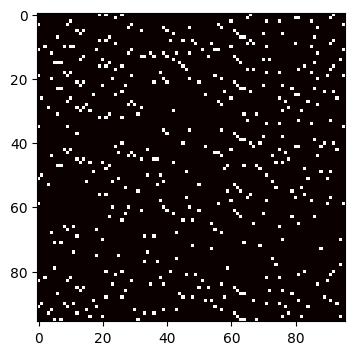

iter=0, cost=408.0 after CVRP
iter=0, cost=408.0 after QAP
iter=1, cost=408.0 after CVRP
iter=1, cost=408.0 after QAP
iter=2, cost=408.0 after CVRP
iter=2, cost=408.0 after QAP
iter=3, cost=408.0 after CVRP
iter=3, cost=408.0 after QAP
iter=4, cost=408.0 after CVRP
iter=4, cost=408.0 after QAP
solution cost=408


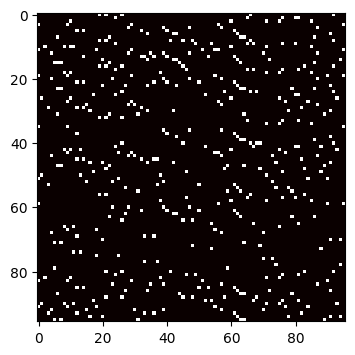

iter=0, cost=401.0 after CVRP
iter=0, cost=401.0 after QAP
iter=1, cost=403.0 after CVRP
iter=1, cost=403.0 after QAP
iter=2, cost=399.0 after CVRP
iter=2, cost=399.0 after QAP
iter=3, cost=399.0 after CVRP
iter=3, cost=399.0 after QAP
iter=4, cost=399.0 after CVRP
iter=4, cost=399.0 after QAP
solution cost=393


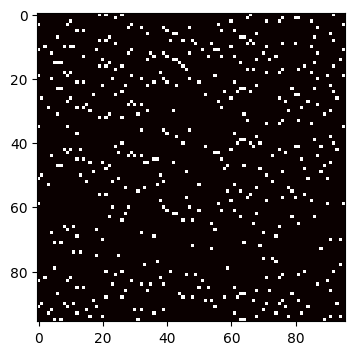

iter=0, cost=429.0 after CVRP
iter=0, cost=429.0 after QAP
iter=1, cost=429.0 after CVRP
iter=1, cost=429.0 after QAP
iter=2, cost=429.0 after CVRP
iter=2, cost=429.0 after QAP
iter=3, cost=429.0 after CVRP
iter=3, cost=429.0 after QAP
iter=4, cost=429.0 after CVRP
iter=4, cost=429.0 after QAP
solution cost=423


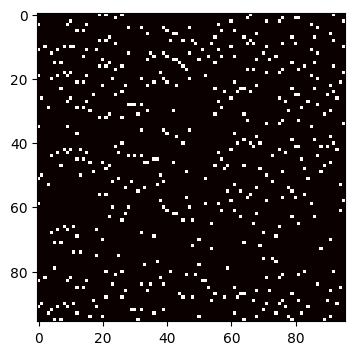

iter=0, cost=425.0 after CVRP
iter=0, cost=417.0 after QAP
iter=1, cost=399.0 after CVRP
iter=1, cost=399.0 after QAP
iter=2, cost=399.0 after CVRP
iter=2, cost=399.0 after QAP
iter=3, cost=399.0 after CVRP
iter=3, cost=399.0 after QAP
iter=4, cost=399.0 after CVRP
iter=4, cost=399.0 after QAP
solution cost=398


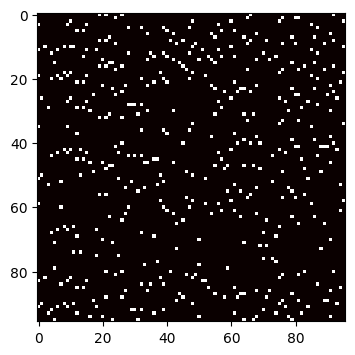

iter=0, cost=419.0 after CVRP
iter=0, cost=411.0 after QAP
iter=1, cost=402.0 after CVRP
iter=1, cost=402.0 after QAP
iter=2, cost=402.0 after CVRP
iter=2, cost=402.0 after QAP
iter=3, cost=402.0 after CVRP
iter=3, cost=402.0 after QAP
iter=4, cost=402.0 after CVRP
iter=4, cost=402.0 after QAP
solution cost=399


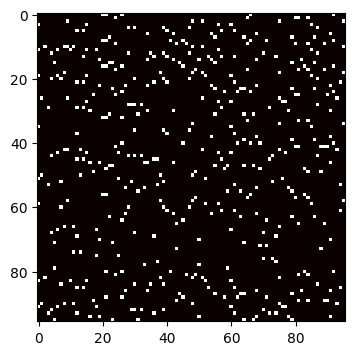

iter=0, cost=421.0 after CVRP
iter=0, cost=416.0 after QAP
iter=1, cost=407.0 after CVRP
iter=1, cost=407.0 after QAP
iter=2, cost=404.0 after CVRP
iter=2, cost=404.0 after QAP
iter=3, cost=404.0 after CVRP
iter=3, cost=404.0 after QAP
iter=4, cost=404.0 after CVRP
iter=4, cost=404.0 after QAP
solution cost=397


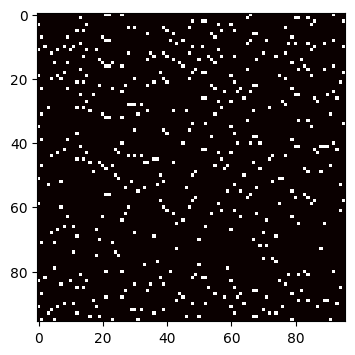

iter=0, cost=419.0 after CVRP
iter=0, cost=419.0 after QAP
iter=1, cost=416.0 after CVRP
iter=1, cost=409.0 after QAP
iter=2, cost=397.0 after CVRP
iter=2, cost=397.0 after QAP
iter=3, cost=397.0 after CVRP
iter=3, cost=397.0 after QAP
iter=4, cost=397.0 after CVRP
iter=4, cost=397.0 after QAP
solution cost=392


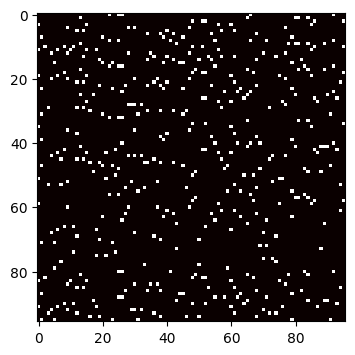

iter=0, cost=415.0 after CVRP
iter=0, cost=415.0 after QAP
iter=1, cost=410.0 after CVRP
iter=1, cost=407.0 after QAP
iter=2, cost=414.0 after CVRP
iter=2, cost=414.0 after QAP
iter=3, cost=400.0 after CVRP
iter=3, cost=399.0 after QAP
iter=4, cost=395.0 after CVRP
iter=4, cost=395.0 after QAP
solution cost=394


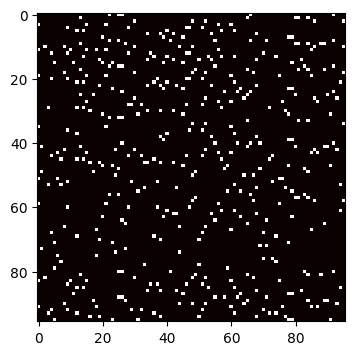

iter=0, cost=414.0 after CVRP
iter=0, cost=412.0 after QAP
iter=1, cost=392.0 after CVRP
iter=1, cost=392.0 after QAP
iter=2, cost=391.0 after CVRP
iter=2, cost=390.0 after QAP
iter=3, cost=393.0 after CVRP
iter=3, cost=393.0 after QAP
iter=4, cost=393.0 after CVRP
iter=4, cost=393.0 after QAP
solution cost=386


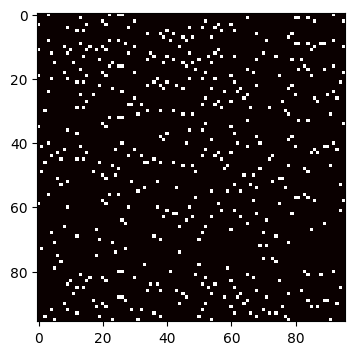

iter=0, cost=406.0 after CVRP
iter=0, cost=403.0 after QAP
iter=1, cost=399.0 after CVRP
iter=1, cost=399.0 after QAP
iter=2, cost=394.0 after CVRP
iter=2, cost=394.0 after QAP
iter=3, cost=394.0 after CVRP
iter=3, cost=394.0 after QAP
iter=4, cost=393.0 after CVRP
iter=4, cost=393.0 after QAP
solution cost=387


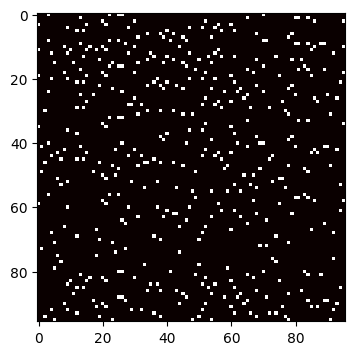

iter=0, cost=399.0 after CVRP
iter=0, cost=398.0 after QAP
iter=1, cost=402.0 after CVRP
iter=1, cost=399.0 after QAP
iter=2, cost=396.0 after CVRP
iter=2, cost=394.0 after QAP
iter=3, cost=395.0 after CVRP
iter=3, cost=395.0 after QAP
iter=4, cost=395.0 after CVRP
iter=4, cost=395.0 after QAP
solution cost=388


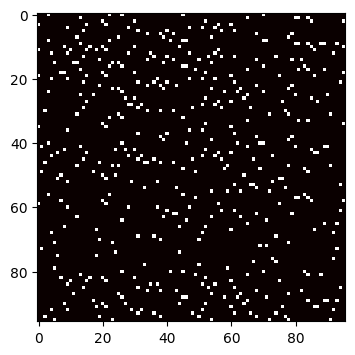

iter=0, cost=410.0 after CVRP
iter=0, cost=409.0 after QAP
iter=1, cost=395.0 after CVRP
iter=1, cost=394.0 after QAP
iter=2, cost=388.0 after CVRP
iter=2, cost=387.0 after QAP
iter=3, cost=385.0 after CVRP
iter=3, cost=385.0 after QAP
iter=4, cost=385.0 after CVRP
iter=4, cost=385.0 after QAP
solution cost=380


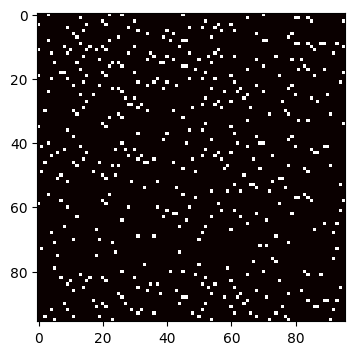

iter=0, cost=412.0 after CVRP
iter=0, cost=410.0 after QAP
iter=1, cost=404.0 after CVRP
iter=1, cost=404.0 after QAP
iter=2, cost=391.0 after CVRP
iter=2, cost=389.0 after QAP
iter=3, cost=392.0 after CVRP
iter=3, cost=392.0 after QAP
iter=4, cost=392.0 after CVRP
iter=4, cost=392.0 after QAP
solution cost=392


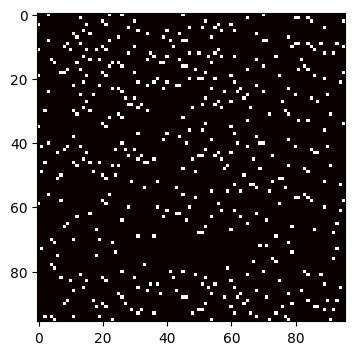

iter=0, cost=408.0 after CVRP
iter=0, cost=408.0 after QAP
iter=1, cost=408.0 after CVRP
iter=1, cost=408.0 after QAP
iter=2, cost=408.0 after CVRP
iter=2, cost=408.0 after QAP
iter=3, cost=408.0 after CVRP
iter=3, cost=408.0 after QAP
iter=4, cost=408.0 after CVRP
iter=4, cost=408.0 after QAP
solution cost=405


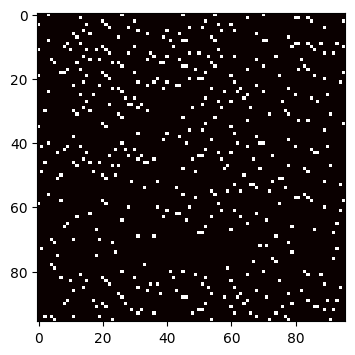

iter=0, cost=394.0 after CVRP
iter=0, cost=392.0 after QAP
iter=1, cost=402.0 after CVRP
iter=1, cost=401.0 after QAP
iter=2, cost=394.0 after CVRP
iter=2, cost=394.0 after QAP
iter=3, cost=394.0 after CVRP
iter=3, cost=394.0 after QAP
iter=4, cost=394.0 after CVRP
iter=4, cost=394.0 after QAP
solution cost=397


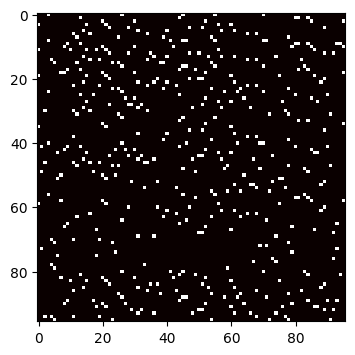

iter=0, cost=404.0 after CVRP
iter=0, cost=402.0 after QAP
iter=1, cost=377.0 after CVRP
iter=1, cost=377.0 after QAP
iter=2, cost=377.0 after CVRP
iter=2, cost=377.0 after QAP
iter=3, cost=377.0 after CVRP
iter=3, cost=377.0 after QAP
iter=4, cost=377.0 after CVRP
iter=4, cost=377.0 after QAP
solution cost=375


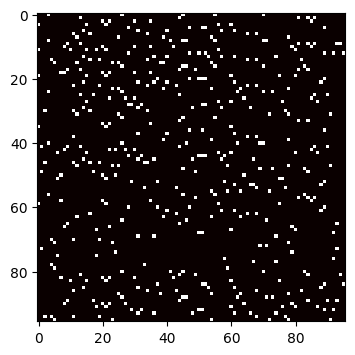

iter=0, cost=406.0 after CVRP
iter=0, cost=404.0 after QAP
iter=1, cost=399.0 after CVRP
iter=1, cost=399.0 after QAP
iter=2, cost=389.0 after CVRP
iter=2, cost=389.0 after QAP
iter=3, cost=389.0 after CVRP
iter=3, cost=389.0 after QAP
iter=4, cost=389.0 after CVRP
iter=4, cost=389.0 after QAP
solution cost=385


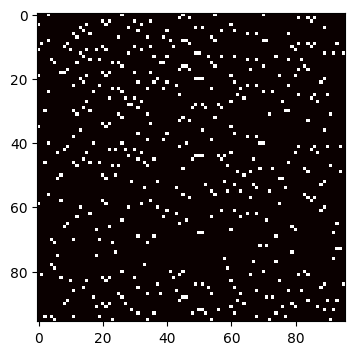

iter=0, cost=406.0 after CVRP
iter=0, cost=406.0 after QAP
iter=1, cost=381.0 after CVRP
iter=1, cost=380.0 after QAP
iter=2, cost=389.0 after CVRP
iter=2, cost=389.0 after QAP
iter=3, cost=390.0 after CVRP
iter=3, cost=390.0 after QAP
iter=4, cost=386.0 after CVRP
iter=4, cost=385.0 after QAP
solution cost=386


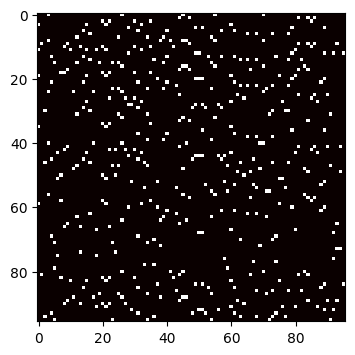

iter=0, cost=409.0 after CVRP
iter=0, cost=402.0 after QAP
iter=1, cost=391.0 after CVRP
iter=1, cost=390.0 after QAP
iter=2, cost=393.0 after CVRP
iter=2, cost=393.0 after QAP
iter=3, cost=393.0 after CVRP
iter=3, cost=393.0 after QAP
iter=4, cost=393.0 after CVRP
iter=4, cost=393.0 after QAP
solution cost=387


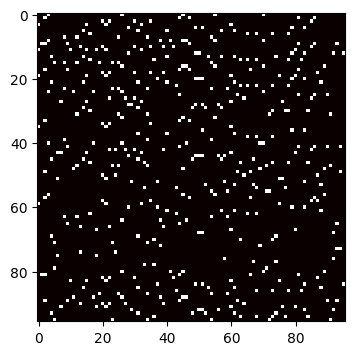

iter=0, cost=408.0 after CVRP
iter=0, cost=406.0 after QAP
iter=1, cost=403.0 after CVRP
iter=1, cost=402.0 after QAP
iter=2, cost=401.0 after CVRP
iter=2, cost=401.0 after QAP
iter=3, cost=401.0 after CVRP
iter=3, cost=401.0 after QAP
iter=4, cost=401.0 after CVRP
iter=4, cost=401.0 after QAP
solution cost=397


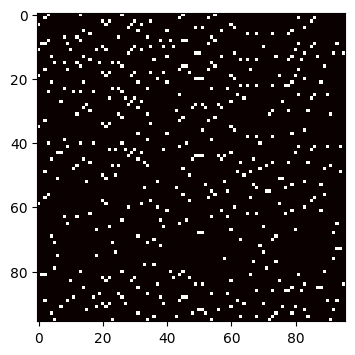

iter=0, cost=404.0 after CVRP
iter=0, cost=397.0 after QAP
iter=1, cost=378.0 after CVRP
iter=1, cost=378.0 after QAP
iter=2, cost=378.0 after CVRP
iter=2, cost=378.0 after QAP
iter=3, cost=378.0 after CVRP
iter=3, cost=378.0 after QAP
iter=4, cost=377.0 after CVRP
iter=4, cost=377.0 after QAP
solution cost=371


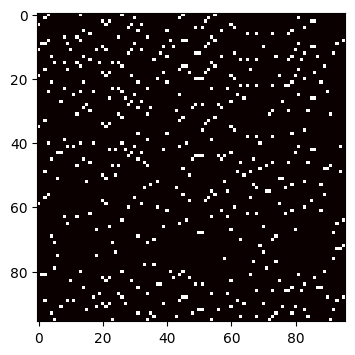

iter=0, cost=404.0 after CVRP
iter=0, cost=398.0 after QAP
iter=1, cost=386.0 after CVRP
iter=1, cost=386.0 after QAP
iter=2, cost=378.0 after CVRP
iter=2, cost=377.0 after QAP
iter=3, cost=370.0 after CVRP
iter=3, cost=370.0 after QAP
iter=4, cost=370.0 after CVRP
iter=4, cost=370.0 after QAP
solution cost=368


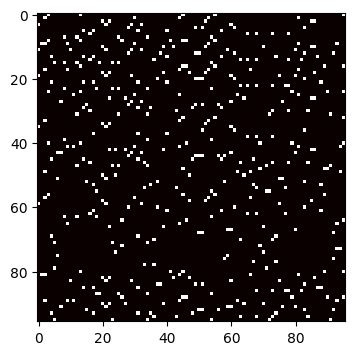

iter=0, cost=414.0 after CVRP
iter=0, cost=413.0 after QAP
iter=1, cost=402.0 after CVRP
iter=1, cost=402.0 after QAP
iter=2, cost=393.0 after CVRP
iter=2, cost=393.0 after QAP
iter=3, cost=377.0 after CVRP
iter=3, cost=376.0 after QAP
iter=4, cost=373.0 after CVRP
iter=4, cost=373.0 after QAP
solution cost=366


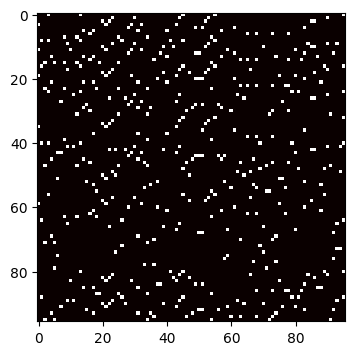

iter=0, cost=420.0 after CVRP
iter=0, cost=420.0 after QAP
iter=1, cost=379.0 after CVRP
iter=1, cost=379.0 after QAP
iter=2, cost=379.0 after CVRP
iter=2, cost=379.0 after QAP
iter=3, cost=379.0 after CVRP
iter=3, cost=379.0 after QAP
iter=4, cost=379.0 after CVRP
iter=4, cost=379.0 after QAP
solution cost=376


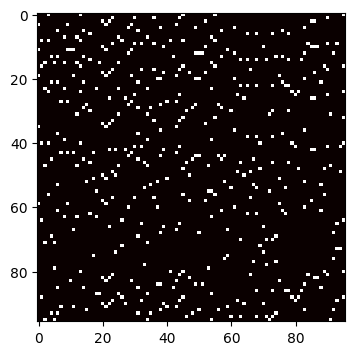

iter=0, cost=421.0 after CVRP
iter=0, cost=421.0 after QAP
iter=1, cost=408.0 after CVRP
iter=1, cost=408.0 after QAP
iter=2, cost=408.0 after CVRP
iter=2, cost=408.0 after QAP
iter=3, cost=408.0 after CVRP
iter=3, cost=408.0 after QAP
iter=4, cost=408.0 after CVRP
iter=4, cost=408.0 after QAP
solution cost=402


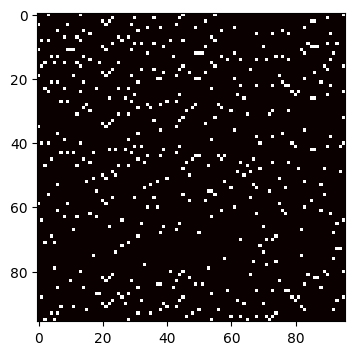

iter=0, cost=409.0 after CVRP
iter=0, cost=409.0 after QAP
iter=1, cost=409.0 after CVRP
iter=1, cost=409.0 after QAP
iter=2, cost=409.0 after CVRP
iter=2, cost=409.0 after QAP
iter=3, cost=409.0 after CVRP
iter=3, cost=409.0 after QAP
iter=4, cost=409.0 after CVRP
iter=4, cost=409.0 after QAP
solution cost=408


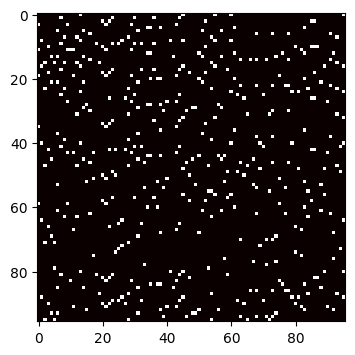

iter=0, cost=404.0 after CVRP
iter=0, cost=404.0 after QAP
iter=1, cost=404.0 after CVRP
iter=1, cost=404.0 after QAP
iter=2, cost=404.0 after CVRP
iter=2, cost=404.0 after QAP
iter=3, cost=404.0 after CVRP
iter=3, cost=404.0 after QAP
iter=4, cost=404.0 after CVRP
iter=4, cost=404.0 after QAP
solution cost=400


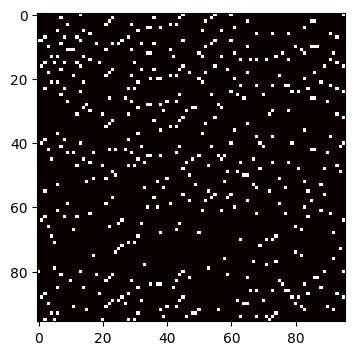

iter=0, cost=412.0 after CVRP
iter=0, cost=411.0 after QAP
iter=1, cost=412.0 after CVRP
iter=1, cost=412.0 after QAP
iter=2, cost=404.0 after CVRP
iter=2, cost=404.0 after QAP
iter=3, cost=400.0 after CVRP
iter=3, cost=402.0 after QAP
iter=4, cost=399.0 after CVRP
iter=4, cost=399.0 after QAP
solution cost=397


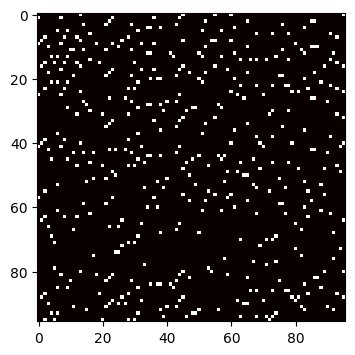

iter=0, cost=417.0 after CVRP
iter=0, cost=415.0 after QAP
iter=1, cost=411.0 after CVRP
iter=1, cost=410.0 after QAP
iter=2, cost=390.0 after CVRP
iter=2, cost=390.0 after QAP
iter=3, cost=390.0 after CVRP
iter=3, cost=390.0 after QAP
iter=4, cost=390.0 after CVRP
iter=4, cost=390.0 after QAP
solution cost=383


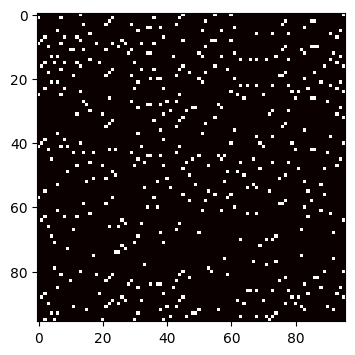

iter=0, cost=409.0 after CVRP
iter=0, cost=407.0 after QAP
iter=1, cost=411.0 after CVRP
iter=1, cost=411.0 after QAP
iter=2, cost=411.0 after CVRP
iter=2, cost=411.0 after QAP
iter=3, cost=411.0 after CVRP
iter=3, cost=411.0 after QAP
iter=4, cost=411.0 after CVRP
iter=4, cost=411.0 after QAP
solution cost=400


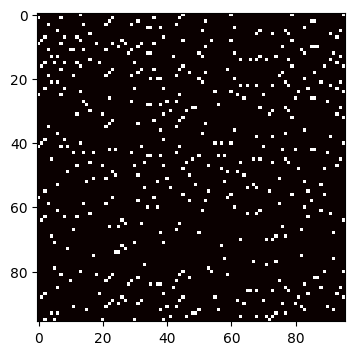

iter=0, cost=413.0 after CVRP
iter=0, cost=411.0 after QAP
iter=1, cost=402.0 after CVRP
iter=1, cost=402.0 after QAP
iter=2, cost=402.0 after CVRP
iter=2, cost=402.0 after QAP
iter=3, cost=402.0 after CVRP
iter=3, cost=402.0 after QAP
iter=4, cost=402.0 after CVRP
iter=4, cost=402.0 after QAP
solution cost=400


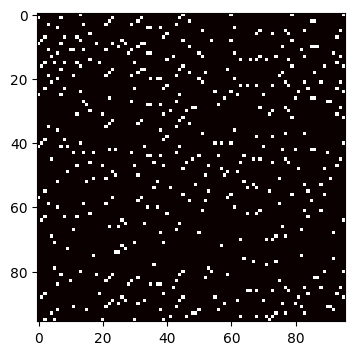

iter=0, cost=414.0 after CVRP
iter=0, cost=414.0 after QAP
iter=1, cost=411.0 after CVRP
iter=1, cost=411.0 after QAP
iter=2, cost=406.0 after CVRP
iter=2, cost=406.0 after QAP
iter=3, cost=406.0 after CVRP
iter=3, cost=406.0 after QAP
iter=4, cost=406.0 after CVRP
iter=4, cost=406.0 after QAP
solution cost=405


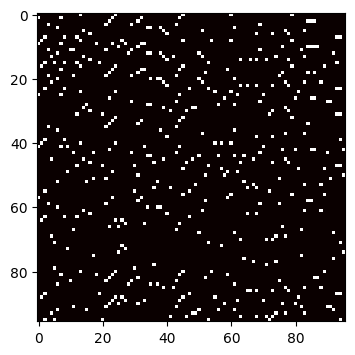

iter=0, cost=415.0 after CVRP
iter=0, cost=413.0 after QAP
iter=1, cost=409.0 after CVRP
iter=1, cost=409.0 after QAP
iter=2, cost=409.0 after CVRP
iter=2, cost=409.0 after QAP
iter=3, cost=409.0 after CVRP
iter=3, cost=409.0 after QAP
iter=4, cost=409.0 after CVRP
iter=4, cost=409.0 after QAP
solution cost=400


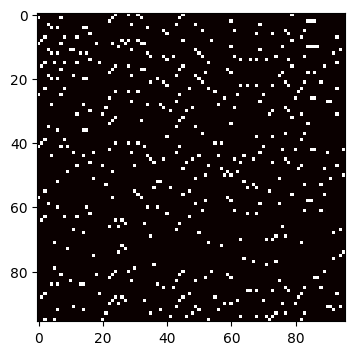

iter=0, cost=401.0 after CVRP
iter=0, cost=401.0 after QAP
iter=1, cost=401.0 after CVRP
iter=1, cost=401.0 after QAP
iter=2, cost=401.0 after CVRP
iter=2, cost=401.0 after QAP
iter=3, cost=401.0 after CVRP
iter=3, cost=401.0 after QAP
iter=4, cost=401.0 after CVRP
iter=4, cost=401.0 after QAP
solution cost=399


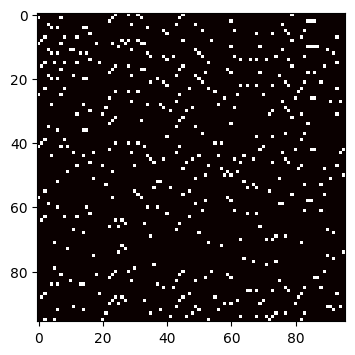

iter=0, cost=403.0 after CVRP
iter=0, cost=400.0 after QAP
iter=1, cost=390.0 after CVRP
iter=1, cost=389.0 after QAP
iter=2, cost=384.0 after CVRP
iter=2, cost=384.0 after QAP
iter=3, cost=390.0 after CVRP
iter=3, cost=390.0 after QAP
iter=4, cost=390.0 after CVRP
iter=4, cost=390.0 after QAP
solution cost=383


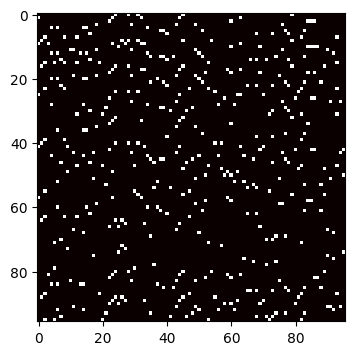

iter=0, cost=414.0 after CVRP
iter=0, cost=414.0 after QAP
iter=1, cost=414.0 after CVRP
iter=1, cost=414.0 after QAP
iter=2, cost=414.0 after CVRP
iter=2, cost=414.0 after QAP
iter=3, cost=414.0 after CVRP
iter=3, cost=414.0 after QAP
iter=4, cost=414.0 after CVRP
iter=4, cost=414.0 after QAP
solution cost=402


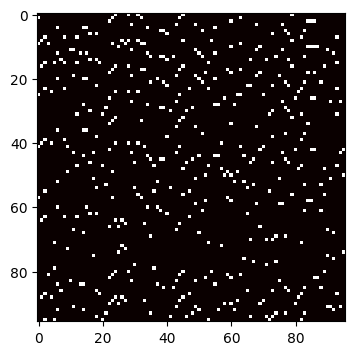

iter=0, cost=410.0 after CVRP
iter=0, cost=408.0 after QAP
iter=1, cost=409.0 after CVRP
iter=1, cost=409.0 after QAP
iter=2, cost=409.0 after CVRP
iter=2, cost=409.0 after QAP
iter=3, cost=409.0 after CVRP
iter=3, cost=409.0 after QAP
iter=4, cost=409.0 after CVRP
iter=4, cost=409.0 after QAP
solution cost=409


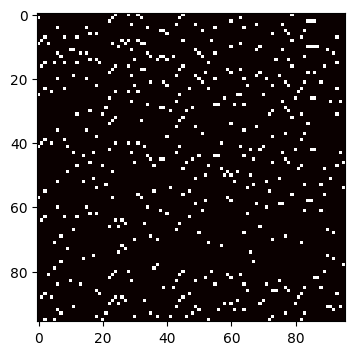

iter=0, cost=409.0 after CVRP
iter=0, cost=407.0 after QAP
iter=1, cost=397.0 after CVRP
iter=1, cost=396.0 after QAP
iter=2, cost=386.0 after CVRP
iter=2, cost=383.0 after QAP
iter=3, cost=373.0 after CVRP
iter=3, cost=373.0 after QAP
iter=4, cost=373.0 after CVRP
iter=4, cost=373.0 after QAP
solution cost=363


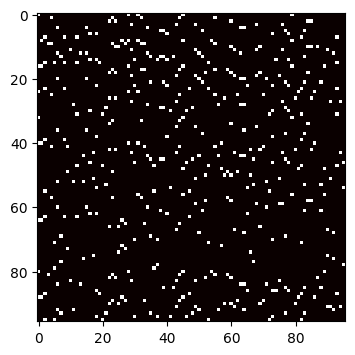

iter=0, cost=401.0 after CVRP
iter=0, cost=399.0 after QAP
iter=1, cost=390.0 after CVRP
iter=1, cost=390.0 after QAP
iter=2, cost=388.0 after CVRP
iter=2, cost=387.0 after QAP
iter=3, cost=395.0 after CVRP
iter=3, cost=395.0 after QAP
iter=4, cost=384.0 after CVRP
iter=4, cost=383.0 after QAP
solution cost=381


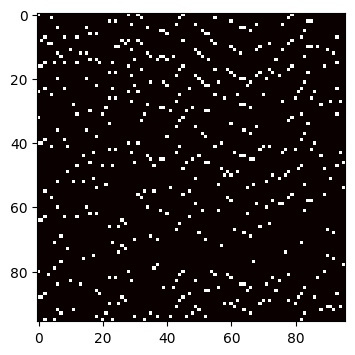

iter=0, cost=409.0 after CVRP
iter=0, cost=409.0 after QAP
iter=1, cost=399.0 after CVRP
iter=1, cost=399.0 after QAP
iter=2, cost=395.0 after CVRP
iter=2, cost=395.0 after QAP
iter=3, cost=383.0 after CVRP
iter=3, cost=382.0 after QAP
iter=4, cost=384.0 after CVRP
iter=4, cost=384.0 after QAP
solution cost=366


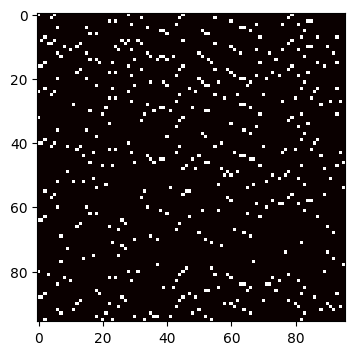

iter=0, cost=406.0 after CVRP
iter=0, cost=405.0 after QAP
iter=1, cost=406.0 after CVRP
iter=1, cost=406.0 after QAP
iter=2, cost=406.0 after CVRP
iter=2, cost=406.0 after QAP
iter=3, cost=406.0 after CVRP
iter=3, cost=406.0 after QAP
iter=4, cost=406.0 after CVRP
iter=4, cost=406.0 after QAP
solution cost=406


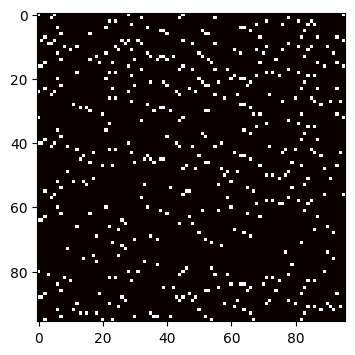

iter=0, cost=411.0 after CVRP
iter=0, cost=408.0 after QAP
iter=1, cost=400.0 after CVRP
iter=1, cost=400.0 after QAP
iter=2, cost=391.0 after CVRP
iter=2, cost=391.0 after QAP
iter=3, cost=391.0 after CVRP
iter=3, cost=391.0 after QAP
iter=4, cost=391.0 after CVRP
iter=4, cost=391.0 after QAP
solution cost=389


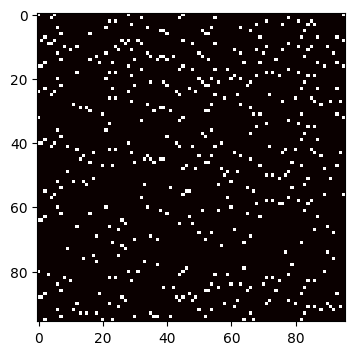

iter=0, cost=404.0 after CVRP
iter=0, cost=403.0 after QAP
iter=1, cost=401.0 after CVRP
iter=1, cost=401.0 after QAP
iter=2, cost=401.0 after CVRP
iter=2, cost=401.0 after QAP
iter=3, cost=401.0 after CVRP
iter=3, cost=401.0 after QAP
iter=4, cost=400.0 after CVRP
iter=4, cost=400.0 after QAP
solution cost=398


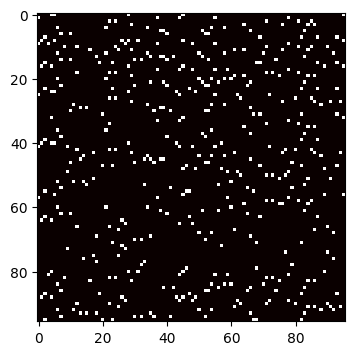

iter=0, cost=404.0 after CVRP
iter=0, cost=403.0 after QAP
iter=1, cost=403.0 after CVRP
iter=1, cost=403.0 after QAP
iter=2, cost=403.0 after CVRP
iter=2, cost=403.0 after QAP
iter=3, cost=403.0 after CVRP
iter=3, cost=403.0 after QAP
iter=4, cost=403.0 after CVRP
iter=4, cost=403.0 after QAP
solution cost=401


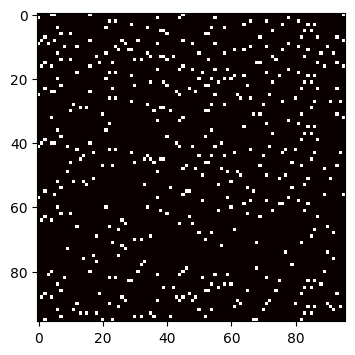

iter=0, cost=410.0 after CVRP
iter=0, cost=411.0 after QAP
iter=1, cost=412.0 after CVRP
iter=1, cost=412.0 after QAP
iter=2, cost=406.0 after CVRP
iter=2, cost=406.0 after QAP
iter=3, cost=407.0 after CVRP
iter=3, cost=407.0 after QAP
iter=4, cost=397.0 after CVRP
iter=4, cost=397.0 after QAP
solution cost=395


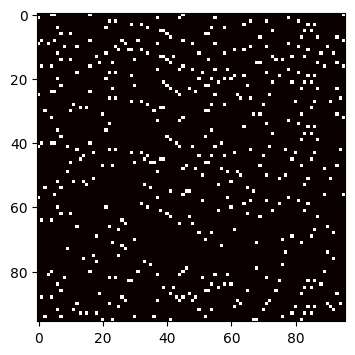

iter=0, cost=405.0 after CVRP
iter=0, cost=405.0 after QAP
iter=1, cost=405.0 after CVRP
iter=1, cost=405.0 after QAP
iter=2, cost=405.0 after CVRP
iter=2, cost=405.0 after QAP
iter=3, cost=405.0 after CVRP
iter=3, cost=405.0 after QAP
iter=4, cost=405.0 after CVRP
iter=4, cost=405.0 after QAP
solution cost=405


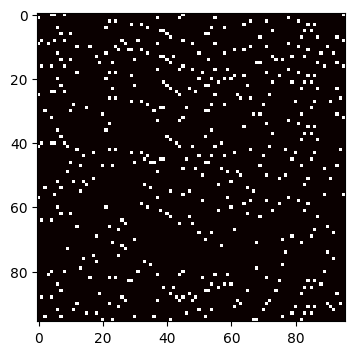

iter=0, cost=413.0 after CVRP
iter=0, cost=413.0 after QAP
iter=1, cost=412.0 after CVRP
iter=1, cost=413.0 after QAP
iter=2, cost=399.0 after CVRP
iter=2, cost=398.0 after QAP
iter=3, cost=391.0 after CVRP
iter=3, cost=391.0 after QAP
iter=4, cost=393.0 after CVRP
iter=4, cost=393.0 after QAP
solution cost=390


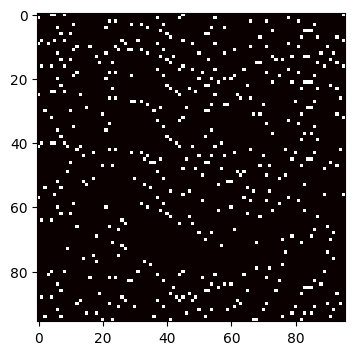

iter=0, cost=412.0 after CVRP
iter=0, cost=409.0 after QAP
iter=1, cost=387.0 after CVRP
iter=1, cost=386.0 after QAP
iter=2, cost=389.0 after CVRP
iter=2, cost=389.0 after QAP
iter=3, cost=393.0 after CVRP
iter=3, cost=393.0 after QAP
iter=4, cost=393.0 after CVRP
iter=4, cost=393.0 after QAP
solution cost=384


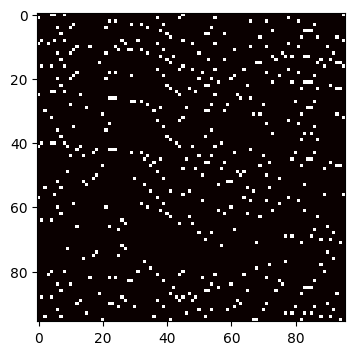

iter=0, cost=408.0 after CVRP
iter=0, cost=408.0 after QAP
iter=1, cost=393.0 after CVRP
iter=1, cost=393.0 after QAP
iter=2, cost=380.0 after CVRP
iter=2, cost=380.0 after QAP
iter=3, cost=380.0 after CVRP
iter=3, cost=380.0 after QAP
iter=4, cost=380.0 after CVRP
iter=4, cost=380.0 after QAP
solution cost=375


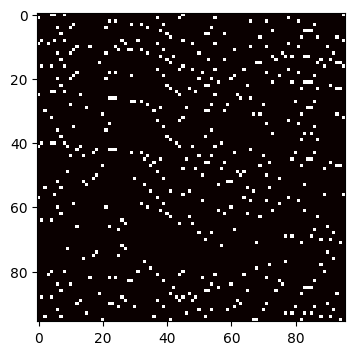

iter=0, cost=408.0 after CVRP
iter=0, cost=408.0 after QAP
iter=1, cost=393.0 after CVRP
iter=1, cost=393.0 after QAP
iter=2, cost=380.0 after CVRP
iter=2, cost=380.0 after QAP
iter=3, cost=380.0 after CVRP
iter=3, cost=380.0 after QAP
iter=4, cost=380.0 after CVRP
iter=4, cost=380.0 after QAP
solution cost=375


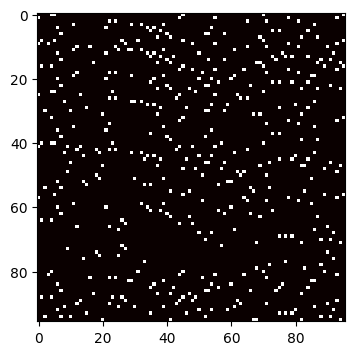

iter=0, cost=404.0 after CVRP
iter=0, cost=401.0 after QAP
iter=1, cost=392.0 after CVRP
iter=1, cost=390.0 after QAP
iter=2, cost=387.0 after CVRP
iter=2, cost=387.0 after QAP
iter=3, cost=387.0 after CVRP
iter=3, cost=387.0 after QAP
iter=4, cost=387.0 after CVRP
iter=4, cost=387.0 after QAP
solution cost=385


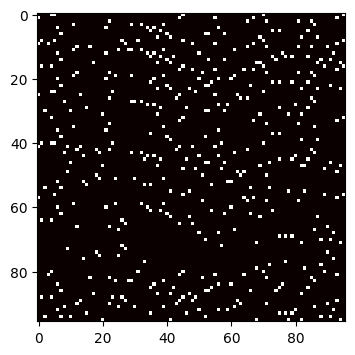

iter=0, cost=398.0 after CVRP
iter=0, cost=397.0 after QAP
iter=1, cost=397.0 after CVRP
iter=1, cost=394.0 after QAP
iter=2, cost=382.0 after CVRP
iter=2, cost=382.0 after QAP
iter=3, cost=382.0 after CVRP
iter=3, cost=382.0 after QAP
iter=4, cost=382.0 after CVRP
iter=4, cost=382.0 after QAP
solution cost=369


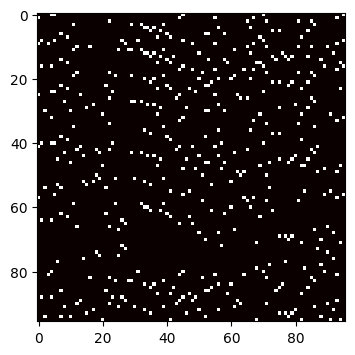

iter=0, cost=388.0 after CVRP
iter=0, cost=388.0 after QAP
iter=1, cost=387.0 after CVRP
iter=1, cost=387.0 after QAP
iter=2, cost=387.0 after CVRP
iter=2, cost=387.0 after QAP
iter=3, cost=387.0 after CVRP
iter=3, cost=387.0 after QAP
iter=4, cost=387.0 after CVRP
iter=4, cost=387.0 after QAP
solution cost=379


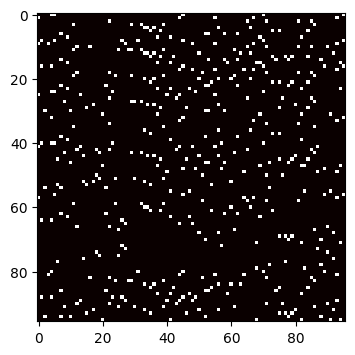

iter=0, cost=398.0 after CVRP
iter=0, cost=396.0 after QAP
iter=1, cost=391.0 after CVRP
iter=1, cost=391.0 after QAP
iter=2, cost=391.0 after CVRP
iter=2, cost=391.0 after QAP
iter=3, cost=391.0 after CVRP
iter=3, cost=391.0 after QAP
iter=4, cost=391.0 after CVRP
iter=4, cost=391.0 after QAP
solution cost=380


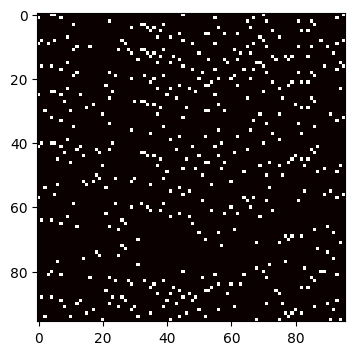

iter=0, cost=397.0 after CVRP
iter=0, cost=393.0 after QAP
iter=1, cost=391.0 after CVRP
iter=1, cost=391.0 after QAP
iter=2, cost=390.0 after CVRP
iter=2, cost=391.0 after QAP
iter=3, cost=391.0 after CVRP
iter=3, cost=391.0 after QAP
iter=4, cost=391.0 after CVRP
iter=4, cost=391.0 after QAP
solution cost=389


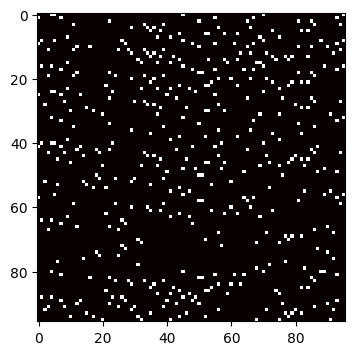

iter=0, cost=398.0 after CVRP
iter=0, cost=397.0 after QAP
iter=1, cost=395.0 after CVRP
iter=1, cost=395.0 after QAP
iter=2, cost=383.0 after CVRP
iter=2, cost=383.0 after QAP
iter=3, cost=379.0 after CVRP
iter=3, cost=378.0 after QAP
iter=4, cost=375.0 after CVRP
iter=4, cost=375.0 after QAP
solution cost=373


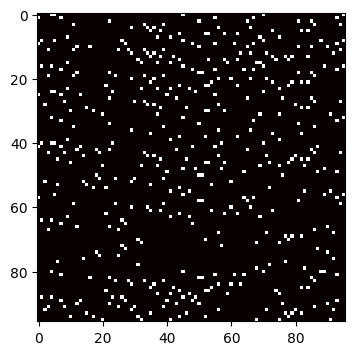

iter=0, cost=398.0 after CVRP
iter=0, cost=397.0 after QAP
iter=1, cost=395.0 after CVRP
iter=1, cost=395.0 after QAP
iter=2, cost=383.0 after CVRP
iter=2, cost=383.0 after QAP
iter=3, cost=379.0 after CVRP
iter=3, cost=378.0 after QAP
iter=4, cost=375.0 after CVRP
iter=4, cost=375.0 after QAP
solution cost=373


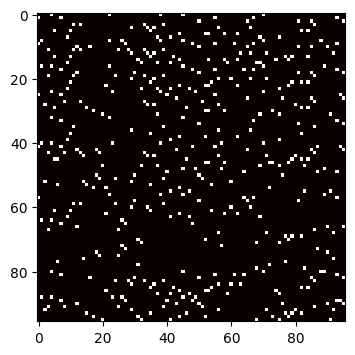

iter=0, cost=399.0 after CVRP
iter=0, cost=399.0 after QAP
iter=1, cost=405.0 after CVRP
iter=1, cost=405.0 after QAP
iter=2, cost=397.0 after CVRP
iter=2, cost=396.0 after QAP
iter=3, cost=389.0 after CVRP
iter=3, cost=388.0 after QAP
iter=4, cost=380.0 after CVRP
iter=4, cost=380.0 after QAP
solution cost=377


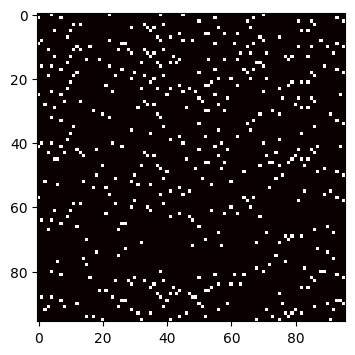

iter=0, cost=402.0 after CVRP
iter=0, cost=402.0 after QAP
iter=1, cost=402.0 after CVRP
iter=1, cost=399.0 after QAP
iter=2, cost=393.0 after CVRP
iter=2, cost=393.0 after QAP
iter=3, cost=388.0 after CVRP
iter=3, cost=386.0 after QAP
iter=4, cost=375.0 after CVRP
iter=4, cost=375.0 after QAP
solution cost=369


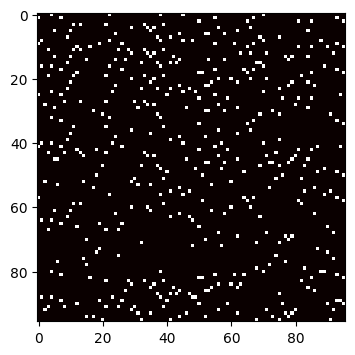

iter=0, cost=407.0 after CVRP
iter=0, cost=400.0 after QAP
iter=1, cost=379.0 after CVRP
iter=1, cost=379.0 after QAP
iter=2, cost=379.0 after CVRP
iter=2, cost=379.0 after QAP
iter=3, cost=381.0 after CVRP
iter=3, cost=381.0 after QAP
iter=4, cost=380.0 after CVRP
iter=4, cost=380.0 after QAP
solution cost=375


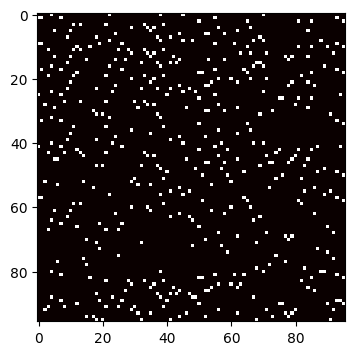

iter=0, cost=407.0 after CVRP
iter=0, cost=403.0 after QAP
iter=1, cost=399.0 after CVRP
iter=1, cost=393.0 after QAP
iter=2, cost=388.0 after CVRP
iter=2, cost=387.0 after QAP
iter=3, cost=385.0 after CVRP
iter=3, cost=385.0 after QAP
iter=4, cost=385.0 after CVRP
iter=4, cost=385.0 after QAP
solution cost=384


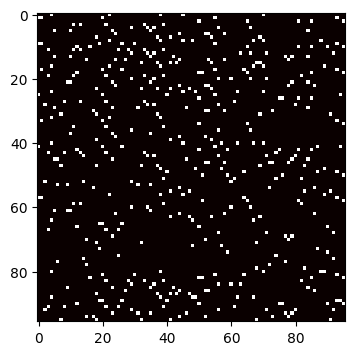

iter=0, cost=397.0 after CVRP
iter=0, cost=393.0 after QAP
iter=1, cost=393.0 after CVRP
iter=1, cost=390.0 after QAP
iter=2, cost=380.0 after CVRP
iter=2, cost=380.0 after QAP
iter=3, cost=376.0 after CVRP
iter=3, cost=375.0 after QAP
iter=4, cost=373.0 after CVRP
iter=4, cost=373.0 after QAP
solution cost=368


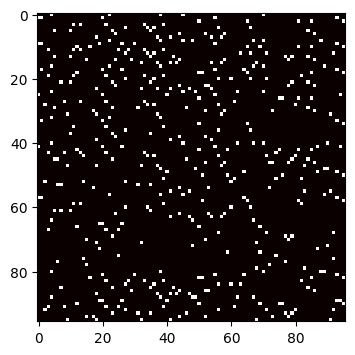

iter=0, cost=406.0 after CVRP
iter=0, cost=399.0 after QAP
iter=1, cost=393.0 after CVRP
iter=1, cost=392.0 after QAP
iter=2, cost=396.0 after CVRP
iter=2, cost=396.0 after QAP
iter=3, cost=396.0 after CVRP
iter=3, cost=396.0 after QAP
iter=4, cost=396.0 after CVRP
iter=4, cost=396.0 after QAP
solution cost=396


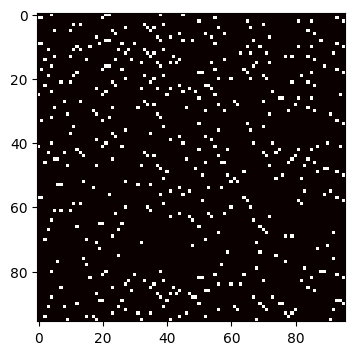

iter=0, cost=399.0 after CVRP
iter=0, cost=399.0 after QAP
iter=1, cost=399.0 after CVRP
iter=1, cost=399.0 after QAP
iter=2, cost=399.0 after CVRP
iter=2, cost=399.0 after QAP
iter=3, cost=399.0 after CVRP
iter=3, cost=399.0 after QAP
iter=4, cost=399.0 after CVRP
iter=4, cost=399.0 after QAP
solution cost=396


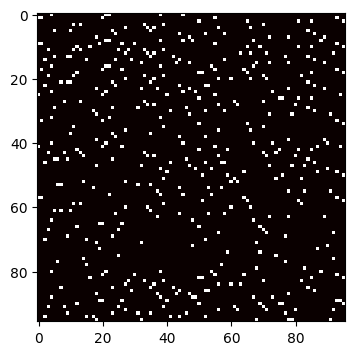

iter=0, cost=400.0 after CVRP
iter=0, cost=398.0 after QAP
iter=1, cost=403.0 after CVRP
iter=1, cost=403.0 after QAP
iter=2, cost=403.0 after CVRP
iter=2, cost=403.0 after QAP
iter=3, cost=403.0 after CVRP
iter=3, cost=403.0 after QAP
iter=4, cost=403.0 after CVRP
iter=4, cost=403.0 after QAP
solution cost=402


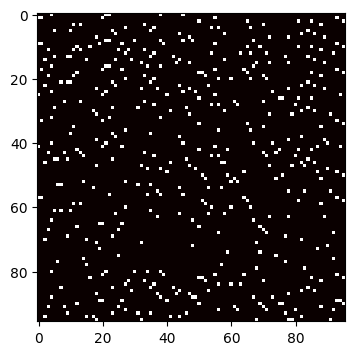

iter=0, cost=404.0 after CVRP
iter=0, cost=404.0 after QAP
iter=1, cost=404.0 after CVRP
iter=1, cost=404.0 after QAP
iter=2, cost=404.0 after CVRP
iter=2, cost=404.0 after QAP
iter=3, cost=404.0 after CVRP
iter=3, cost=404.0 after QAP
iter=4, cost=404.0 after CVRP
iter=4, cost=404.0 after QAP
solution cost=401


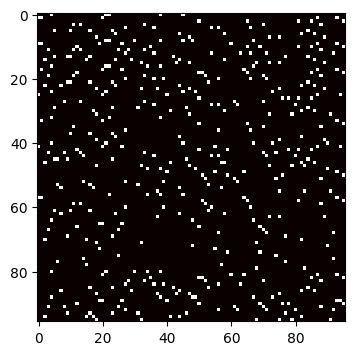

iter=0, cost=405.0 after CVRP
iter=0, cost=395.0 after QAP
iter=1, cost=397.0 after CVRP
iter=1, cost=397.0 after QAP
iter=2, cost=397.0 after CVRP
iter=2, cost=397.0 after QAP
iter=3, cost=385.0 after CVRP
iter=3, cost=384.0 after QAP
iter=4, cost=381.0 after CVRP
iter=4, cost=381.0 after QAP
solution cost=380


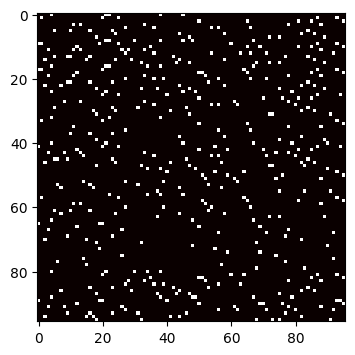

iter=0, cost=409.0 after CVRP
iter=0, cost=408.0 after QAP
iter=1, cost=398.0 after CVRP
iter=1, cost=398.0 after QAP
iter=2, cost=398.0 after CVRP
iter=2, cost=398.0 after QAP
iter=3, cost=398.0 after CVRP
iter=3, cost=398.0 after QAP
iter=4, cost=398.0 after CVRP
iter=4, cost=398.0 after QAP
solution cost=398


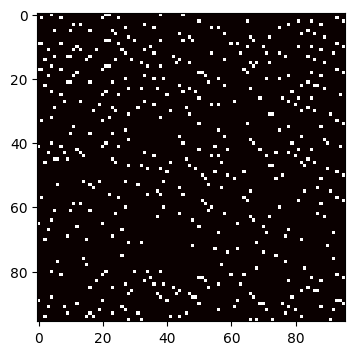

iter=0, cost=413.0 after CVRP
iter=0, cost=412.0 after QAP
iter=1, cost=403.0 after CVRP
iter=1, cost=403.0 after QAP
iter=2, cost=389.0 after CVRP
iter=2, cost=388.0 after QAP
iter=3, cost=387.0 after CVRP
iter=3, cost=385.0 after QAP
iter=4, cost=394.0 after CVRP
iter=4, cost=394.0 after QAP
solution cost=384


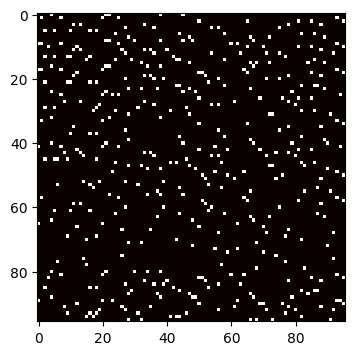

iter=0, cost=415.0 after CVRP
iter=0, cost=413.0 after QAP
iter=1, cost=406.0 after CVRP
iter=1, cost=406.0 after QAP
iter=2, cost=409.0 after CVRP
iter=2, cost=407.0 after QAP
iter=3, cost=396.0 after CVRP
iter=3, cost=396.0 after QAP
iter=4, cost=396.0 after CVRP
iter=4, cost=396.0 after QAP
solution cost=393


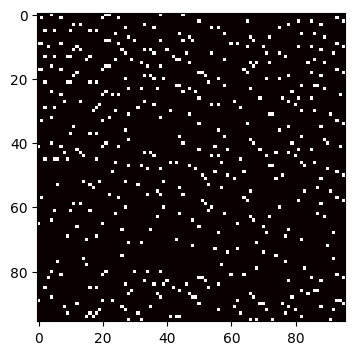

iter=0, cost=406.0 after CVRP
iter=0, cost=402.0 after QAP
iter=1, cost=395.0 after CVRP
iter=1, cost=395.0 after QAP
iter=2, cost=395.0 after CVRP
iter=2, cost=395.0 after QAP
iter=3, cost=395.0 after CVRP
iter=3, cost=395.0 after QAP
iter=4, cost=395.0 after CVRP
iter=4, cost=395.0 after QAP
solution cost=394


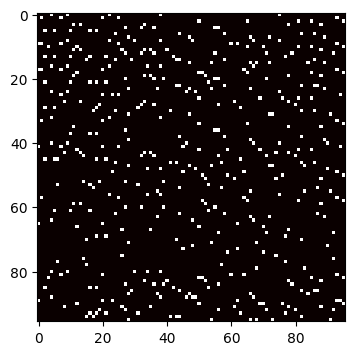

iter=0, cost=421.0 after CVRP
iter=0, cost=421.0 after QAP
iter=1, cost=421.0 after CVRP
iter=1, cost=421.0 after QAP
iter=2, cost=421.0 after CVRP
iter=2, cost=421.0 after QAP
iter=3, cost=421.0 after CVRP
iter=3, cost=421.0 after QAP
iter=4, cost=421.0 after CVRP
iter=4, cost=421.0 after QAP
solution cost=420


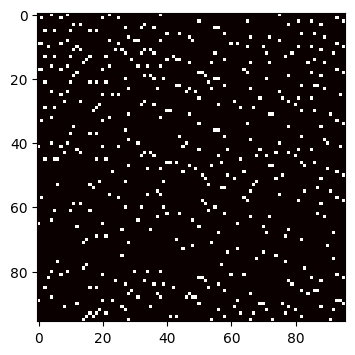

iter=0, cost=415.0 after CVRP
iter=0, cost=411.0 after QAP
iter=1, cost=403.0 after CVRP
iter=1, cost=403.0 after QAP
iter=2, cost=403.0 after CVRP
iter=2, cost=403.0 after QAP
iter=3, cost=403.0 after CVRP
iter=3, cost=403.0 after QAP
iter=4, cost=403.0 after CVRP
iter=4, cost=403.0 after QAP
solution cost=397


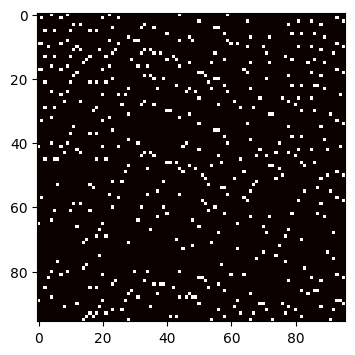

iter=0, cost=411.0 after CVRP
iter=0, cost=411.0 after QAP
iter=1, cost=411.0 after CVRP
iter=1, cost=411.0 after QAP
iter=2, cost=411.0 after CVRP
iter=2, cost=411.0 after QAP
iter=3, cost=411.0 after CVRP
iter=3, cost=411.0 after QAP
iter=4, cost=411.0 after CVRP
iter=4, cost=411.0 after QAP
solution cost=410


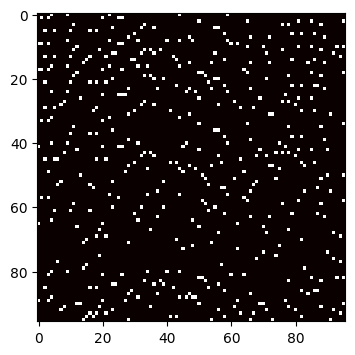

iter=0, cost=410.0 after CVRP
iter=0, cost=410.0 after QAP
iter=1, cost=410.0 after CVRP
iter=1, cost=410.0 after QAP
iter=2, cost=410.0 after CVRP
iter=2, cost=410.0 after QAP
iter=3, cost=410.0 after CVRP
iter=3, cost=410.0 after QAP
iter=4, cost=410.0 after CVRP
iter=4, cost=410.0 after QAP
solution cost=410


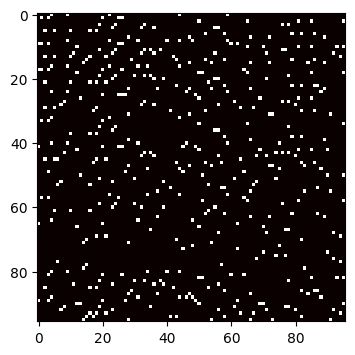

iter=0, cost=419.0 after CVRP
iter=0, cost=419.0 after QAP
iter=1, cost=419.0 after CVRP
iter=1, cost=419.0 after QAP
iter=2, cost=419.0 after CVRP
iter=2, cost=419.0 after QAP
iter=3, cost=419.0 after CVRP
iter=3, cost=419.0 after QAP
iter=4, cost=419.0 after CVRP
iter=4, cost=419.0 after QAP
solution cost=417


In [13]:
column_permutation = np.eye(96)
# Function to swap two columns in a matrix
def swap_columns(matrix, col1, col2):
    matrix[:, [col1, col2]] = matrix[:, [col2, col1]]
# record the optimized distance and non-optimized distance in each permutation
update_a = a
stat = []
non_optimized_distance, optimized_distance = matrix_to_sequence(update_a)
stat.append((0,non_optimized_distance,optimized_distance))
# pick an integer from 0 to 10 with gaussian distribution
for i in range(100):
    num_permutation = np.random.normal(5, 2)
    num_permutation = int(num_permutation)
    # randomly swipe two columns n times
    for j in range(num_permutation):
        exchange_columns = np.random.choice(96, 2, replace=False)
        swap_columns(column_permutation, exchange_columns[0], exchange_columns[1])
    update_a = np.dot(a, column_permutation)
    show_matrix(update_a)
    non_optimized_distance, optimized_distance = matrix_to_sequence(update_a)
    stat.append((i+1,non_optimized_distance,optimized_distance))
stat = np.array(stat)

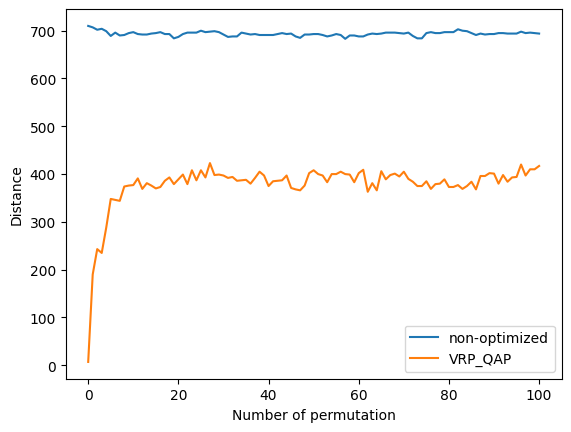

In [14]:
# plot the result
plt.plot(stat[:,0],stat[:,1],label='non-optimized')
plt.plot(stat[:,0],stat[:,2],label='VRP_QAP')
plt.legend()
plt.xlabel('Number of permutation')
plt.ylabel('Distance')
plt.show()
